## Defining Hypotheses

- Shooting from close-range is more valuable than shooting from distance
- The performance of long-range shots is less stable season by season than the performance of short-range shots

## Obtaining Data

To study the stability of shooting data, we scraped shooting data from https://fbref.com from the 2015/2016 season to the current 2024/2025 season.
Starting from the 2015/2016 season is largely an arbitaryy choice.
This data was saved to a csv file and loaded thus.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf 
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid", palette="colorblind")

In [2]:
data = pd.read_csv("../../datasets/epl_shooting_data.csv")

## Exploring Data

In [3]:
# Print the columns as a list
print(list(data.columns))

['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born', '90s', 'Gls', 'Sh', 'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT', 'Dist', 'PK', 'PKatt', 'Matches', 'season', 'FK', 'Expected_xG', 'Expected_npxG', 'Expected_npxG/Sh', 'Expected_G-xG', 'Expected_np:G-xG']


In [4]:
# Print the first 5 rows of the DataFrame 'data'
print(data.head())

  Rk               Player   Nation Pos          Squad Age  Born   90s Gls  \
0  1  Patrick van Aanholt   nl NED  DF     Sunderland  24  1990  33.0   4   
1  2       Rolando Aarons  eng ENG  MF  Newcastle Utd  19  1995   4.2   1   
2  3           Almen Abdi   ch SUI  MF        Watford  28  1986  21.9   2   
3  4        Tammy Abraham  eng ENG  FW        Chelsea  17  1997   0.6   0   
4  5         Charlie Adam  sct SCO  MF     Stoke City  29  1985  11.6   1   

    Sh  ... PK PKatt  Matches     season   FK Expected_xG Expected_npxG  \
0  NaN  ...  0     0  Matches  2015-2016  NaN         NaN           NaN   
1  NaN  ...  0     0  Matches  2015-2016  NaN         NaN           NaN   
2  NaN  ...  0     0  Matches  2015-2016  NaN         NaN           NaN   
3  NaN  ...  0     0  Matches  2015-2016  NaN         NaN           NaN   
4  NaN  ...  0     0  Matches  2015-2016  NaN         NaN           NaN   

  Expected_npxG/Sh Expected_G-xG Expected_np:G-xG  
0              NaN           NaN  

In [5]:
print(data["Player"])

0       Patrick van Aanholt
1            Rolando Aarons
2                Almen Abdi
3             Tammy Abraham
4              Charlie Adam
               ...         
5650         Illia Zabarnyi
5651    Oleksandr Zinchenko
5652                 Player
5653         Joshua Zirkzee
5654        Martin Ødegaard
Name: Player, Length: 5655, dtype: object


## Filtering Data 

In [6]:
# Checking for NaN values in 'Dist'
missing_values = data["Dist"].isna().sum()

# Drop rows if there are any missing values in 'Dist'
if missing_values > 0:
    data = data.dropna(subset=["Dist"])
    print("Dropped rows with NaN values in 'Dist'.")
else:
    print("No missing values found in 'Dist'.")

Dropped rows with NaN values in 'Dist'.


## Feature Engineering

Here, we categorize average shot distance for each player into long and short and put it in a new feature shot length.

In [7]:
# Convert 'Dist' column to numeric, coercing errors to NaN (if any conversion fails)
data = data.copy()  # Ensure it's an independent copy
data["Dist"] = pd.to_numeric(data["Dist"], errors='coerce')

# Categorise average shot distance 
data["shot_length"] = np.where(data["Dist"] >= 18, "long", "short")

## Summarizing Data 

Briefly we examined some basic numbers used to describe the shooting distance data.

In [8]:
data["Dist"].describe()

count    3581.000000
mean       17.339933
std         5.425552
min         0.900000
25%        13.400000
50%        17.100000
75%        21.000000
max        56.100000
Name: Dist, dtype: float64

#### Analysis and Interpretation of Results
- The count is the number of records in the dataset spanning nine seasons. There are 3581 shooting distance data in the dataset.
- The mean is the average of this data. What this tells us is that on average, every player shot 17 meters.
- The std is the standard deviation. The standard deviation (std) of 5.4 meters tells us how much the shooting distances of players typically vary from the average (which is 17 meters). Because the data is normally distributed (see fig xxx), using the empirical rule (68-95-99.7 rule), which applies to data that follows a normal distribution (or approximately normal), Most shots (about 68% if the data is normally distributed) are within one standard deviation of the mean—so between 11.6 meters (17 - 5.4) and 22.4 meters (17 + 5.4). About 95% of shots are within two standard deviations—so between 6.2 meters (17 - 2 × 5.4) and 27.8 meters (17 + 2 × 5.4).
- The min is the minimum shooting distance in the records. The minimum shooting distance is therefore 0.9 meters? Which player shot that?
- The 25%, 50%, and 75% numbers represent the quartiles of the shooting distance data. If we divide the shooting distance data into four equal halves, 25% (Q1) = 13.4 meters → A quarter of the shots were taken from 13.4 meters or less. 50% (Q2 / Median) = 17.1 meters → Half of the shots were taken from 17.1 meters or less. This is the middle value of the dataset. 75% (Q3) = 21.0 meters → Three-quarters of the shots were taken from 21 meters or less.
- The max is the maximum shooting distance in the records. A value of 56.10 means a player shot up to that but no player shot more than that in the nine season under consideration. Which player shot that?

 



####  Detecting outliers in the "Dist" (shooting distance) column using the 1.5 × IQR rule

In [9]:
# Extract shooting distance column
distances = data["Dist"]

# Calculate Q1, Q3, and IQR
Q1 = distances.quantile(0.25)
Q3 = distances.quantile(0.75)
IQR = Q3 - Q1

# Compute lower and upper bounds for outliers
lower_bound = Q1 - (1.5 * IQR)
upper_bound = Q3 + (1.5 * IQR)

# Identify outliers
outliers = data[(distances < lower_bound) | (distances > upper_bound)]

# Display outliers
print(outliers[["Player", "Squad", "Dist"]])  # Show only relevant columns

                  Player           Squad  Dist
1292         Tom Edwards      Stoke City  34.1
1408       Ragnar Klavan       Liverpool   0.9
1429     Victor Lindelöf  Manchester Utd  34.4
1489        Tyrone Mings     Bournemouth  35.7
1523          Allan Nyom       West Brom  35.3
1669          Ben Watson         Watford  32.9
1927     Stefan Johansen          Fulham  33.2
2578       Jeremy Ngakia        West Ham  33.2
2656   Kasper Schmeichel  Leicester City  56.1
2812        Ross Barkley         Chelsea  35.9
2988      José Izquierdo        Brighton  32.6
3002            Jorginho         Chelsea  47.9
3037  Maxime Le Marchand          Fulham  34.1
3087      James McCarthy  Crystal Palace  32.5
3335      Daniel Amartey  Leicester City  34.1
3567            Jorginho         Chelsea  32.6
3771       Morgan Sanson     Aston Villa  33.2
4153            Jorginho         Chelsea  34.1
4875      Oliver Norwood   Sheffield Utd  32.9
4936            Tim Ream          Fulham   1.3
5086    Emman

#### **Analysis and Interpretation**

##### **1. Outlier Characteristics**
- The identified outliers have shooting distances that are either exceptionally **long-range (≥32.5 meters)** or **very close-range (≤1.5 meters)**.
- **Extremely long-range shots** (e.g., Kasper Schmeichel at 56.1 meters, Jorginho at 47.9 meters) often indicate goalkeepers or defensive players attempting shots from their own half.
- **Extremely short-range shots** (e.g., Takehiro Tomiyasu at 1.2 meters, Tim Ream at 1.3 meters) typically occur in goalmouth situations, possibly tap-ins or rebounds.

##### **2. Players with Long-Range Shooting Distances**
- **Defensive Players & Midfielders:** Many outliers with long-range shots (e.g., Jorginho, Oliver Norwood, Tom Edwards) are midfielders or defenders, who tend to attempt speculative long shots.
- **Goalkeepers:** Kasper Schmeichel's 56.1-meter shot stands out as an unusual event, possibly a clearance or an attempt from deep in his own half.

##### **3. Players with Short-Range Shooting Distances**
- **Close-Range Finishers:** Tim Ream and Takehiro Tomiyasu's extremely short shooting distances suggest they were involved in goalmouth action, possibly from set-piece situations.
- **Rare Events:** Defenders and midfielders appearing in this category may indicate unique in-game situations rather than a consistent shooting pattern.

#### Descriptive statistics for short distance shots

In [10]:
data\
    .query('shot_length == "short"')["Dist"]\
    .describe()

count    2023.000000
mean       13.520415
std         3.023560
min         0.900000
25%        11.400000
50%        13.900000
75%        16.050000
max        17.900000
Name: Dist, dtype: float64

#### Analysis and Interpretation of Results
- The count is the number of records in the dataset spanning nine seasons. There are 2023 shooting distance data that qualifies as short distanced in the dataset.
- The mean is the average of this data. What this tells us is that on average, every short distanced shot fired by a player is about 13 meters.
- The std is the standard deviation. The standard deviation (std) of 3 meters tells us how much the shooting distances of players for short distanced shots typically vary from the average (which is 13 meters). 
- The min is the minimum shooting distance for short distanced shots in the records. The minimum shooting distance is therefore 0.9 meters? 
- The 25%, 50%, and 75% numbers represent the quartiles of the shooting distance data. If we divide the shooting distance data for short distanced shots into four equal halves, 25% (Q1) = 11.4 meters → A quarter of the shots were taken from 11.4 meters or less. 50% (Q2 / Median) = 13.9 meters → Half of the shots were taken from 13.9 meters or less. This is the middle value of the dataset. 75% (Q3) = 16.1 meters → Three-quarters of the shots were taken from 16 meters or less.
- The max is the maximum shooting distance for short distanced shots in the records.


#### Descriptive statistics for long distance shots

In [11]:
data\
    .query('shot_length == "long"')["Dist"]\
    .describe()

count    1558.000000
mean       22.299422
std         3.499128
min        18.000000
25%        19.700000
50%        21.600000
75%        24.200000
max        56.100000
Name: Dist, dtype: float64

#### Analysis and Interpretation of Results
- The count is the number of records in the dataset spanning nine seasons. There are 1558 shooting distance data that qualifies as long distanced in the dataset.
- The mean is the average of this data. What this tells us is that on average, every long distanced shot fired by a player is about 22 meters.
- The std is the standard deviation. The standard deviation (std) of 3.5 meters tells us how much the shooting distances of players for long distanced shots typically vary from the average (which is 22 meters). 
- The min is the minimum shooting distance for long distanced shots in the records. The minimum shooting distance is therefore 18 meters? 
- The 25%, 50%, and 75% numbers represent the quartiles of the shooting distance data. If we divide the shooting distance data for long distanced shots into four equal halves, 25% (Q1) = 19.7 meters → A quarter of the shots were taken from 19.7 meters or less. 50% (Q2 / Median) = 21.6 meters → Half of the shots were taken from 21.6 meters or less. This is the middle value of the dataset. 75% (Q3) = 24.2 meters → Three-quarters of the shots were taken from 24.2 meters or less.
- The max is the maximum shooting distance for long distanced shots in the records.

## Plotting Data

### Histograms

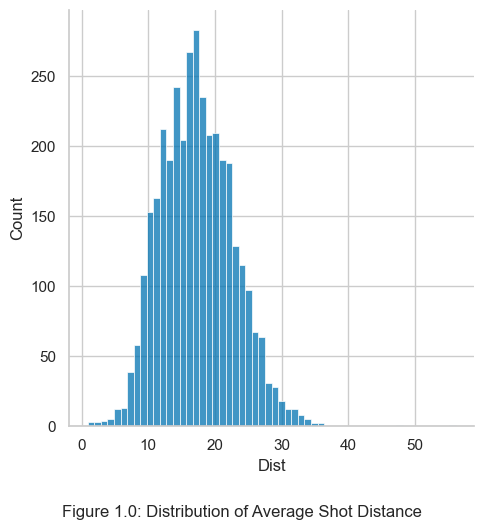

In [12]:
sns.displot(data=data, x="Dist");
plt.figtext(0.5, -0.05, "Figure 1.0: Distribution of Average Shot Distance", ha="center", fontsize=12)
plt.savefig("../../plots/shot_distance_distribution.png", dpi=300, bbox_inches="tight")
plt.show();

#### Analysis and Interpretation
##### Shape:
The distribution appears to be roughly normal, with a peak around **15-20 meters** and a slight skew towards longer distances.

##### Insights:
- Most shots occur between **10 to 25 meters**.
- The presence of some **longer shots (above 30 meters)** suggests a few outliers, but they are relatively rare.
- This suggests that players take most of their shots from **mid-range** rather than extreme short or long distances.


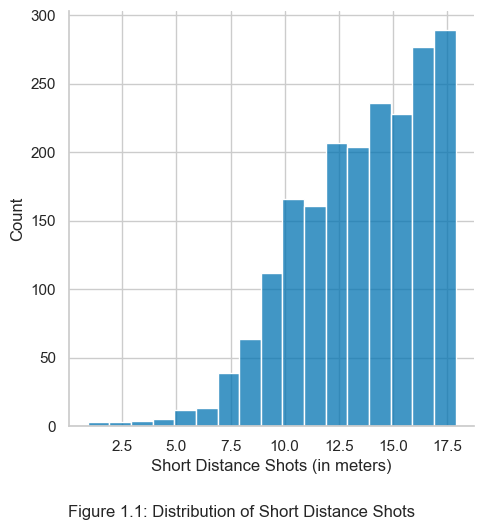

In [13]:
data_short = \
    data\
    .query('shot_length == "short"')
data_hist_short = \
       sns.displot(data=data_short,
                binwidth=1,
                x="Dist");
data_hist_short\
    .set_axis_labels("Short Distance Shots (in meters)", "Count"
        );
plt.figtext(0.5, -0.05, "Figure 1.1: Distribution of Short Distance Shots", ha="center", fontsize=12)
plt.savefig("../../plots/short_distance_shots_distribution.png", dpi=300, bbox_inches="tight")
plt.show();

#### Analysis and Interpretation

##### Shape:
This distribution is **positively skewed (right-skewed)**, meaning that as distance increases, the frequency of shots also increases.

##### Insights:
- A significant portion of shots happens at distances between **10 to 18 meters**.
- The increasing trend suggests that players prefer taking shots from **further out** within the short-range category, possibly just outside the penalty area.
- Very few shots are taken from **extremely close range (under 5 meters)**, which could indicate defensive pressure or limited shooting opportunities near the goal.


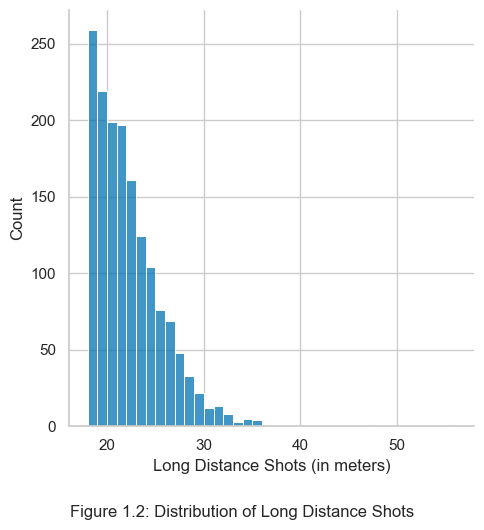

In [14]:
data_long = \
    data\
    .query('shot_length == "long"')
data_hist_long = \
       sns.displot(data=data_long,
                binwidth=1,
                x="Dist");
data_hist_long\
    .set_axis_labels("Long Distance Shots (in meters)", "Count"
        );
plt.figtext(0.5, -0.05, "Figure 1.2: Distribution of Long Distance Shots", ha="center", fontsize=12)
plt.savefig("../../plots/long_distance_shots_distribution.png", dpi=300, bbox_inches="tight")
plt.show();

#### Analysis and Interpretation

##### Shape:
This distribution is **negatively skewed (left-skewed)**, meaning the frequency of shots decreases as distance increases.

##### Insights:
- The highest frequency of long-distance shots occurs just above **20 meters**.
- The number of shots significantly drops as the distance increases, meaning players **rarely attempt shots beyond 30 meters**.
- This is expected since **long-range shots** have lower accuracy and conversion rates, making them less favorable.

### Boxplots

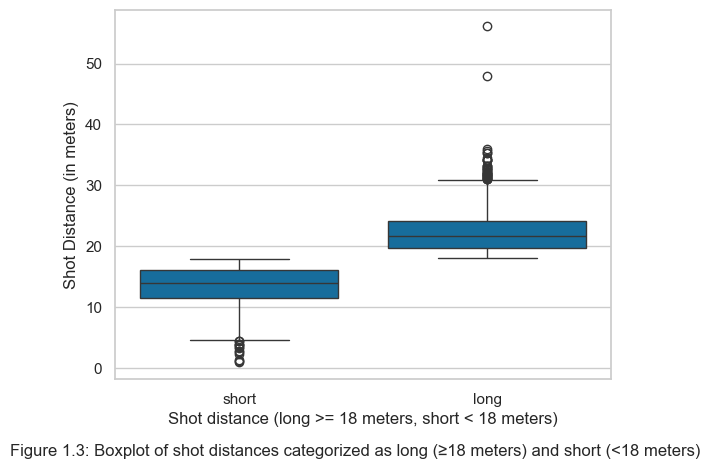

In [15]:
shot_boxplot = \
    sns.boxplot(data=data,
                x="shot_length",
                y="Dist");
shot_boxplot.set(xlabel="Shot distance (long >= 18 meters, short < 18 meters)",
    ylabel="Shot Distance (in meters)",
);
plt.figtext(0.5, -0.05, 
    "Figure 1.3: Boxplot of shot distances categorized as long (≥18 meters) and short (<18 meters)", 
    ha="center", fontsize=12)
plt.savefig("../../plots/boxplot_shot_distances.png", dpi=300, bbox_inches="tight")
plt.show();

#### **Analysis and Interpretation**
- **Summary:** The boxplot categorizes shot distances into two groups: "short" (<18 meters) and "long" (≥18 meters).
- **Observations:**
  - The median shot distance for "short" shots is around 13-14 meters, with an interquartile range (IQR) roughly between 10 and 17 meters.
  - The median for "long" shots is approximately 22-24 meters, with a wider IQR.
  - "Long" shots have significantly more outliers beyond 30 meters, some exceeding 50 meters.
  - "Short" shots also have outliers below 5 meters.
- **Insights:**
  - The distribution of "long" shots is more spread out, suggesting greater variation in shot selection from distance.
  - There are extreme long-distance shots, which could indicate rare attempts from very far.
  - Short shots are more clustered, meaning they are generally taken from more predictable distances.


## 📌 Player-Level Stability of Shot Quality per Attempt

### 🎯 Objective:
To analyze how consistently players generate quality chances (measured by **Expected Goals**, or **xG**) relative to how often they shoot, grouped by **shot type** (long or short) and **season**.

---

### 🔍 Data Summary and Feature Description

#### 🧮 Grouping Data:
We group the dataset by **player**, **season**, and **shot length** (`short` vs `long`) to compute:
- Total number of shots (`Sh`)
- Total non-penalty expected goals (`Expected_npxG`)

Then we calculate:

#### ⚖️ `xg_per_shot`:
This metric represents the **average quality of a shot**, based on the expected goal value per attempt.  
- A higher `xg_per_shot` suggests that the player typically shoots from positions with a higher chance of scoring.
- A lower value may reflect **long-range efforts**, poor shot selection, or shots taken under pressure.

In [16]:
# Grouping by player and season and shot length
data_s = data.groupby(["Player", "season", "shot_length"])\
    .agg({
        "Expected_npxG": "sum",  # Total expected goals (non-penalty)
        "Sh": "sum"              # Total shots
    })

# Ensure data types are correct
data_s['Sh'] = pd.to_numeric(data_s['Sh'], errors='coerce').fillna(0).astype(int)
data_s['Expected_npxG'] = pd.to_numeric(data_s['Expected_npxG'], errors='coerce').fillna(0)

# Compute Expected Goals per Shot (xG/Shot)
data_s['xg_per_shot'] = data_s['Expected_npxG'] / data_s['Sh']
data_s['xg_per_shot'] = data_s['xg_per_shot'].fillna(0)

# Reset index to make 'Player' and 'season' columns available
data_s = data_s.reset_index()

# Sort by xG per shot
data_s = data_s.sort_values(by="xg_per_shot", ascending=False)

# Display results
print(data_s[['Player', 'season', 'shot_length', 'xg_per_shot', 'Sh']].head())

              Player     season shot_length  xg_per_shot  Sh
3254        Tim Ream  2023-2024       short          1.0   1
2799   Ragnar Klavan  2017-2018       short          0.9   1
841   DeAndre Yedlin  2019-2020       short          0.8   1
370       Ben Gibson  2018-2019       short          0.7   1
65        Adam Smith  2024-2025       short          0.6   1


#### 🗂️ **What Each Column Means:**

- **`Player`**: The footballer who took the shots.
- **`season`**: The season during which the shots were taken.
- **`shot_length`**: Whether the shot was from a **long** or **short** distance (based on a threshold like 18 yards).
- **`xg_per_shot`**: The average **expected goal value** per shot.
- **`Sh`**: Total number of shots taken in that category for that player-season.

---

#### ❗ Observations:
- All top entries have **only 1 shot**, leading to a high `xg_per_shot` value. This suggests:
  - These shots were taken from **very close range** (e.g., tap-ins).
  - The small sample size makes it unreliable to draw broader conclusions.
- Many players listed are **defenders** (or even goalkeepers), indicating these are likely **one-off chances**, such as a corner scramble or late-game opportunity.

---

#### 🔎 What This Tells Us:
- While `xg_per_shot` is a **useful efficiency metric**, it's most meaningful when players have taken **multiple shots**.
- Sorting by this metric without considering the number of attempts can **inflate the impact of outliers**.
- It’s a good idea to follow up by filtering players with **at least 50 or 100 shots** to analyze more consistent contributors.

#### Filtering Players with at least 100 attempts (shots)

In [17]:
# Filter for players with at least 100 shots
data_s_100 = data_s.query("Sh >= 100")

# Sort by xG per shot
data_s_100_sorted = data_s_100.sort_values(by="xg_per_shot", ascending=False)

# Display top players
print(data_s_100_sorted[['Player', 'season', 'shot_length', 'xg_per_shot', 'Sh']].head())

               Player     season shot_length  xg_per_shot   Sh
1046   Erling Haaland  2023-2024       short     0.202655  113
1045   Erling Haaland  2022-2023       short     0.198276  116
1151    Gabriel Jesus  2019-2020       short     0.174000  100
933   Dominic Solanke  2023-2024       short     0.162264  106
2427    Mohamed Salah  2017-2018       short     0.159155  142


#### **Breakdown of the Output**

1. **`Player`**:  
   The name of the player.

2. **`season`**:  
   The specific season in which the performance data was recorded (e.g., 2023-2024).

3. **`shot_length`**:  
   Categorization of shot distances—here focused on “short” range shots.

4. **`xg_per_shot`**:  
   Average **expected goals generated per shot**. This provides insight into shot quality rather than just volume.  
   - For instance, **Erling Haaland (2023-2024)** had an xG/Shot of **0.20**, meaning each of his shots had, on average, a 20% chance of scoring.

5. **`Sh` (Shots)**:  
   The total number of shots taken by the player during that season. Players in this table all had **at least 100 attempts**, making their xG/Shot values statistically more reliable than single-shot outliers.

---

### **Key Observations**

1. **High xG per Shot with High Volume**  
   - Players like **Erling Haaland**, **Gabriel Jesus**, and **Dominic Solanke** exhibit **both quality and quantity**—they consistently take a lot of shots and do so from advantageous positions.
   - Their **xG per shot ranges from ~0.16 to 0.20**, indicating strong positioning and efficient shot selection.

2. **Consistency Across Seasons**  
   - Haaland appears in multiple seasons with similar xG/Shot values, reflecting a consistently high standard in shot quality and offensive output.

3. **High Shot Volume = Offensive Centrality**  
   - These players play a central role in their team’s attack. High shot counts (100+) suggest they're frequently involved in build-up and finishing sequences.

4. **Short-Range Focus**  
   - The dominance of the “short” shot_length category among top performers further suggests that players who take more shots closer to goal tend to generate higher xG per attempt—underscoring the value of proximity and shot location.

---

### **Next Steps and Deeper Analysis**

- **Shot Maps and Heatmaps**: Visualize where players take their shots from to understand spatial tendencies behind their xG efficiency.
- **Compare with Goal Conversion**: Analyze how well xG per shot aligns with actual goals scored per shot to identify under- or overperformers.
- **Track Across Seasons**: Monitor whether players maintain or improve their xG/Shot ratios over multiple seasons for insights into development and consistency.

We explored the later in the next section.

## **Stability Analysis of Long-Range vs. Short-Range Shot Performance**

In this analysis, we examine whether the performance of **long-range shots** is less stable than **short-range shots** season by season. To assess this, we focus on the **Expected Goals per Shot (xG per shot)** for each player across multiple seasons, differentiating between long and short shots.

---

#### **Steps to Evaluate Stability:**

1. **Calculate xG per Shot for Each Player in Each Season**:  
   For each player, we calculate **Expected Goals per Shot (xG per shot)** for both short and long-range shots during each season. This is the **Expected Non-penalty xG (Expected_npxG)** divided by the number of shots taken (**Sh**) for each shot length (short or long).

2. **Calculate xG per Shot for the Previous Season**:  
   We then compute the **xG per shot** for the previous season of each player. This allows us to compare the player's performance in one season with that of the next, giving us insight into any fluctuations in their shooting efficiency.

3. **Analyze the Correlation Between Current and Previous Season’s xG per Shot**:  
   Finally, we assess the **correlation** between the **current season’s xG per shot** and the **previous season’s xG per shot**. A strong positive correlation would indicate that a player's shooting performance is consistent from one season to the next, while a weak correlation suggests greater variability. This analysis is particularly useful for distinguishing between **long-range** and **short-range shots**, as these may show different levels of stability.
---

#### **Data Processing and Calculation of xG per Shot**

1. **Data Grouping**:  
   The data is grouped by **player**, **season**, and **shot length** (short or long), aggregating **Expected Non-penalty xG (Expected_npxG)** and **shots (Sh)**.

2. **Numeric Data Handling**:  
   To ensure the values are suitable for analysis, the **Expected_npxG** and **Sh** columns are converted to numeric types, with any non-numeric values coerced to `NaN` and then filled accordingly.

3. **Calculation of xG per Shot**:  
   The **xG per shot** is calculated by dividing **Expected_npxG** by **Sh**, and any missing values are filled with zero to ensure complete data.

4. **Filtering Players**:  
   Only players who have sufficient shot volume are considered for further analysis. The filter is set to include players with at least:
   - **100 shots** for **short-range shots**
   - **30 shots** for **long-range shots**

5. **Lagging Data for Comparison**:  
   A copy of the data is created for the **previous season’s performance**, with the season adjusted by adding 1 to the start year. This allows for direct comparison between the current and previous season's **xG per shot**.

6. **Merging Current and Lagged Data**:  
   The current and lagged data sets are merged on the player, season, and shot length to create a final dataset with both **current and previous season xG per shot** for comparison.

In [18]:
# Group by player, season, and shot length
data_s_pl = data.groupby(["Player", "season", "shot_length"])\
    .agg({
        "Expected_npxG": "sum",
        "Sh": "sum"
    })

# Ensure numeric types
data_s_pl['Expected_npxG'] = pd.to_numeric(data_s_pl['Expected_npxG'], errors='coerce').fillna(0)
data_s_pl['Sh'] = pd.to_numeric(data_s_pl['Sh'], errors='coerce').fillna(0).astype(int)

# Compute xG per shot
data_s_pl['xg_per_shot'] = data_s_pl['Expected_npxG'] / data_s_pl['Sh']
data_s_pl['xg_per_shot'] = data_s_pl['xg_per_shot'].fillna(0)

# Reset index
data_s_pl = data_s_pl.reset_index()

# Filter players with sufficient shot volume
q_value = '(Sh >= 100 & shot_length == "short") | (Sh >= 30 & shot_length == "long")'
data_s_pl = data_s_pl.query(q_value).reset_index(drop=True)

# Create a copy for lagging season data
shots_xg_py = data_s_pl[["Player", "season", "shot_length", "xg_per_shot"]].copy()
shots_xg_lag_py = shots_xg_py.copy()

# Adjust season for lag (next year's performance)
shots_xg_lag_py["start_year"] = shots_xg_lag_py["season"].str.split('-').str[0].astype(int)
shots_xg_lag_py["start_year"] += 1
shots_xg_lag_py["season"] = shots_xg_lag_py["start_year"].astype(str) + '-' + (shots_xg_lag_py["start_year"] + 1).astype(str)
shots_xg_lag_py = shots_xg_lag_py.drop(columns="start_year")

# Rename for merging
shots_xg_lag_py.rename(columns={'xg_per_shot': 'xg_per_shot_last'}, inplace=True)

# Merge current and lagged performance
data_s_pl = shots_xg_py.merge(
    shots_xg_lag_py,
    how='inner',
    on=['Player', 'season', 'shot_length']
)

In [19]:
# Result: players with both current and past season data for xG per shot
print(f"Number of players with valid consecutive seasons: {len(data_s_pl.Player.unique())}")

Number of players with valid consecutive seasons: 72


### Scatterplot of stability data

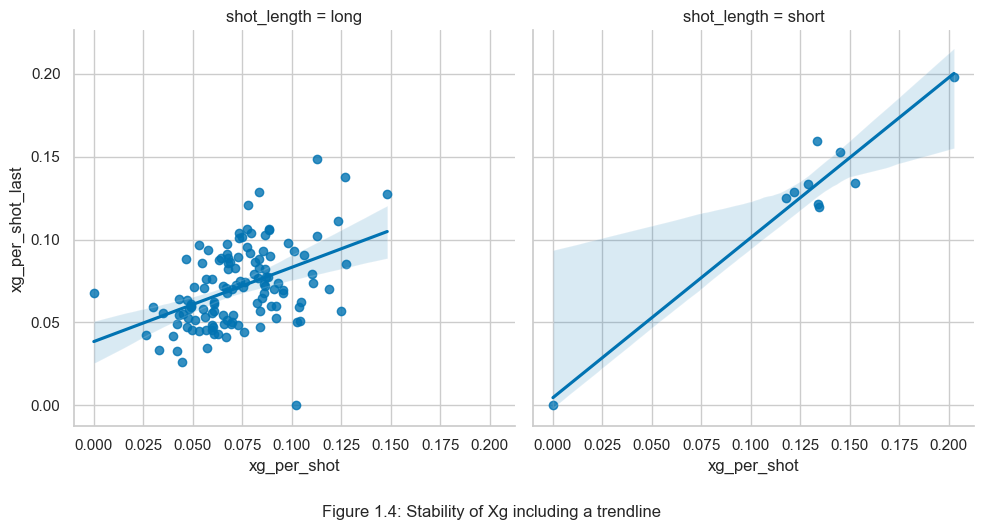

In [20]:
sns.lmplot(data=data_s_pl,
           x="xg_per_shot",
           y="xg_per_shot_last",
           col="shot_length");
plt.figtext(0.5, -0.05, 
    "Figure 1.4: Stability of Xg including a trendline", 
    ha="center", fontsize=12)
plt.savefig("../../plots/scatterplot_shot_distances.png", dpi=300, bbox_inches="tight")
plt.show();

#### **Analysis and Interpretation**
- **Summary:** The scatterplot visualizes the relationship between `xg_per_shot` and `xg_per_shot_last`, separately for **long** and **short** shots.
- **Observations:**
  - For **long shots**, there is a positive trend, but the data is quite scattered, reinforcing the weak correlation seen in the matrix.
  - For **short shots**, the points are tightly clustered around the trendline, indicating much stronger consistency between current and past xG per shot.
- **Insights:**
  - Long shot efficiency varies widely across time, suggesting that external factors—like shot distance, defensive pressure, and game context—may heavily influence outcomes.
  - Short shots tend to yield more stable xG values, reflecting higher predictability in performance.
  - For modeling or decision-making based on prior performance (e.g., scouting, player evaluation), **xG from short shots is a more reliable and stable indicator** than from long shots.

### Correlation Matrix of Xg for long and short ranged shots

                              xg_per_shot  xg_per_shot_last
shot_length                                                
long        xg_per_shot          1.000000          0.443187
            xg_per_shot_last     0.443187          1.000000
short       xg_per_shot          1.000000          0.965200
            xg_per_shot_last     0.965200          1.000000


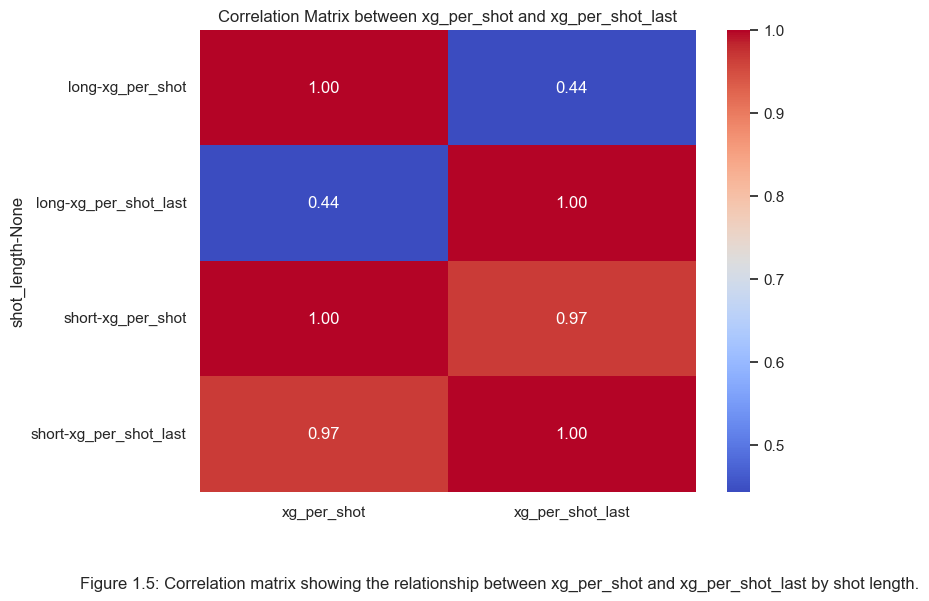

In [21]:
# Calculate the correlation matrix
corr_matrix = data_s_pl\
    .query("xg_per_shot.notnull() & xg_per_shot_last.notnull()")\
    .groupby("shot_length")[["xg_per_shot", "xg_per_shot_last"]]\
    .corr()
print(corr_matrix)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Correlation Matrix between xg_per_shot and xg_per_shot_last")
plt.figtext(0.5, -0.05, "Figure 1.5: Correlation matrix showing the relationship between xg_per_shot and xg_per_shot_last by shot length.", 
            ha="center", fontsize=12)
plt.savefig("../../plots/correlation_matrix_yp.png", dpi=300, bbox_inches="tight")
plt.show()

#### **Analysis and Interpretation**
- **Summary:** This heatmap illustrates the correlation between current `xg_per_shot` and past `xg_per_shot_last` for short and long shots.
- **Observations:**
  - The correlation between long shot xG per shot and its past value is **0.44**, indicating a weak-to-moderate relationship.
  - The correlation for short shot xG per shot and its past value is significantly higher at **0.97**, suggesting strong stability over time.
- **Insights:**
  - Short shots show much stronger consistency in efficiency compared to long shots.
  - Long shot xG is less predictable from previous values, likely due to greater variability influenced by situational factors like distance, angle, or defensive pressure.
  - For predictive modeling or performance evaluation, focusing on short shots offers a more **reliable and stable indicator** of a player's finishing ability.

### xG (Expected Goals) for the top 10 players for long and short shots taken during two specific seasons (2022-2023 and 2023-2024)

#### Leaderboard for 2022-2023 long-ranged shooting xG

In [22]:
print(data_s_pl\
    .query('shot_length == "long" & season == "2022-2023"'
        )[["Player", "xg_per_shot"]]\
    .sort_values(["xg_per_shot"], ascending=False)\
    .head(10))

                     Player  xg_per_shot
76          Martin Ødegaard     0.106452
4       Alexis Mac Allister     0.091250
67          Kevin De Bruyne     0.086154
15          Bruno Fernandes     0.085556
25             Demarai Gray     0.082456
46           James Maddison     0.079518
27            Dwight McNeil     0.076087
51        James Ward-Prowse     0.062500
102         Pierre Højbjerg     0.060606
122  Trent Alexander-Arnold     0.060000


#### Leaderboard for 2022-2023 short-ranged shooting xG

In [23]:
print(data_s_pl\
    .query('shot_length == "short" & season == "2022-2023"'
        )[["Player", "xg_per_shot"]]\
    .sort_values(["xg_per_shot"], ascending=False)\
    .head(10))

           Player  xg_per_shot
89  Mohamed Salah     0.152893
39     Harry Kane     0.134677
21   Daniel James     0.000000


#### Leaderboard for 2023-2024 long-ranged shooting xG

In [24]:
print(data_s_pl\
    .query('shot_length == "long" & season == "2023-2024"'
        )[["Player", "xg_per_shot"]]\
    .sort_values(["xg_per_shot"], ascending=False)\
    .head(10))

                 Player  xg_per_shot
57          John McGinn     0.125000
47       James Maddison     0.110345
52    James Ward-Prowse     0.104762
2            Alex Iwobi     0.103922
29         Eberechi Eze     0.101220
8       Andreas Pereira     0.088462
91   Morgan Gibbs-White     0.087143
26         Douglas Luiz     0.086364
83        Michael Olise     0.083929
128             Willian     0.083721


#### Leaderboard for 2023-2024 short-ranged shooting xG

In [25]:
print(data_s_pl\
    .query('shot_length == "short" & season == "2023-2024"'
        )[["Player", "xg_per_shot"]]\
    .sort_values(["xg_per_shot"], ascending=False)\
    .head(10))

            Player  xg_per_shot
32  Erling Haaland     0.202655
90   Mohamed Salah     0.144860


#### **Analysis and Interpretation**

1. **For the 2022-2023 season, long shots**:

   The top 10 players with the highest **xG per shot from long-range efforts** during the 2022–2023 season are:

   | Player                  | xG per Shot |
   |-------------------------|-------------|
   | Martin Ødegaard         | 0.1065      |
   | Alexis Mac Allister     | 0.0913      |
   | Kevin De Bruyne         | 0.0862      |
   | Bruno Fernandes         | 0.0856      |
   | Demarai Gray            | 0.0825      |
   | James Maddison          | 0.0795      |
   | Dwight McNeil           | 0.0761      |
   | James Ward-Prowse       | 0.0625      |
   | Pierre Højbjerg         | 0.0606      |
   | Trent Alexander-Arnold  | 0.0600      |

   - This list consists largely of midfielders and creative playmakers who often find themselves in advanced shooting positions outside the box.
   - **Martin Ødegaard** stands out with the highest xG per shot from distance (0.1065), indicating high shot quality or intelligent shot selection even from long range.
   - Players like **James Ward-Prowse** and **Alexander-Arnold**, known for set-pieces and long-range strikes, appear with slightly lower xG values — reflecting either lower shooting frequency or more speculative attempts.

2. **For the 2022-2023 season, short shots**:

   The top short-range finishers by **xG per shot** are:

   | Player        | xG per Shot |
   |---------------|-------------|
   | Mohamed Salah | 0.1529      |
   | Harry Kane    | 0.1347      |
   | Daniel James  | 0.0000      |

   - **Mohamed Salah** leads the group with a high short-shot xG, reflecting his consistent ability to get into excellent scoring positions near goal.
   - **Harry Kane** follows closely, reinforcing his status as a composed and efficient finisher in the penalty area.
   - The 0.000 xG value for **Daniel James** likely reflects very few or extremely low-quality short-range shots, suggesting limited involvement in high-probability scoring areas.

3. **For the 2023-2024 season, long shots**:

   The top 10 players with the highest **xG per long shot** in the 2023–2024 season are:

   | Player                  | xG per Shot |
   |-------------------------|-------------|
   | John McGinn             | 0.1250      |
   | James Maddison          | 0.1103      |
   | James Ward-Prowse       | 0.1048      |
   | Alex Iwobi              | 0.1039      |
   | Eberechi Eze            | 0.1012      |
   | Andreas Pereira         | 0.0885      |
   | Morgan Gibbs-White      | 0.0871      |
   | Douglas Luiz            | 0.0864      |
   | Michael Olise           | 0.0839      |
   | Willian                 | 0.0837      |

   - **John McGinn** claims the top spot with a surprisingly high xG per long shot (0.1250), suggesting a more central shooting role or improved shot selection this season.
   - Notably, **Maddison**, **Ward-Prowse**, and **Eze** are repeat names, showing sustained quality in long-range shooting across seasons.
   - The spread of values indicates more shot consistency in long-range players this season compared to 2022–2023.

4. **For the 2023-2024 season, short shots**:

   The leading players for **short-range xG per shot** are:

   | Player         | xG per Shot |
   |----------------|-------------|
   | Erling Haaland | 0.2027      |
   | Mohamed Salah  | 0.1449      |

   - **Erling Haaland** dominates with a massive xG per shot of 0.2027 — a figure that reflects not just his elite finishing but also the extremely high-value chances he receives (i.e., close-range tap-ins or shots within the 6-yard box).
   - **Mohamed Salah** maintains his strong performance from the prior season, reinforcing his consistency and intelligent positioning in high xG areas.
   - The smaller sample size of top short shooters highlights how few players consistently generate elite-quality close-range chances.

---

#### **Key Insights**

1. **Long Shots**:
   - The xG per shot for long-range efforts tends to be lower overall, which is expected due to the increased difficulty and lower conversion rates from distance.
   - That said, players like **Ward-Prowse**, **Maddison**, and **De Bruyne** are consistently in the top ranks, demonstrating not just shot volume but also efficient shot selection.
   - **John McGinn’s** emergence at the top in 2023–2024 marks a notable improvement and could reflect a tactical shift or increased confidence in shooting from distance.

2. **Short Shots**:
   - Short-range shooting shows higher and more stable xG values across both seasons, with stars like **Salah** and **Kane** regularly appearing at the top.
   - **Erling Haaland’s** extraordinary xG per short shot in 2023–2024 (0.2027) underscores his elite goal-scoring profile — not just through volume but through the sheer quality of chances.

3. **Evolution and Stability**:
   - The repeated presence of players like **Salah**, **Maddison**, and **Ward-Prowse** across seasons indicates strong year-over-year reliability.
   - Compared to long-range efforts, **short shots exhibit stronger correlation** and predictive power, reinforcing earlier analyses that suggest **xG from short-range shots is more stable over time**.
   - These insights align with the heatmap and scatterplot findings: **short shots provide a more consistent and reliable metric when analyzing xG trends**, while **long shots exhibit higher variance and are more influenced by external situational factors**.

#### xG values for Martin Ødegaard and Alexis Mac Allister across different seasons.

In [26]:
print(data_s_pl[["shot_length", "Player",
                 "season", "xg_per_shot", "xg_per_shot_last"]] \
      .query('Player == "Martin Ødegaard" | Player == "Alexis Mac Allister"') \
      .sort_values(["Player", "shot_length", "season"]) \
      .to_string())

   shot_length               Player     season  xg_per_shot  xg_per_shot_last
4         long  Alexis Mac Allister  2022-2023     0.091250          0.070175
5         long  Alexis Mac Allister  2023-2024     0.067442          0.091250
76        long      Martin Ødegaard  2022-2023     0.106452          0.090566
77        long      Martin Ødegaard  2023-2024     0.077333          0.106452
78        long      Martin Ødegaard  2024-2025     0.087879          0.077333


#### **Analysis and Interpretation**

The printed output shows the **xG per shot** values for **Martin Ødegaard** and **Alexis Mac Allister** across multiple seasons for **long-range shooting**.

#### **For Martin Ødegaard**:
- In **2022–2023**, his xG per long shot was **0.1065**, slightly up from the previous season’s **0.0906**, suggesting an improvement in either shot selection or quality.
- In **2023–2024**, his xG per long shot **dropped to 0.0773**, indicating either a tendency toward lower-quality chances from distance or more speculative efforts.
- In **2024–2025**, there’s a mild rebound to **0.0879**, but it still remains below his peak in 2022–2023.

#### **For Alexis Mac Allister**:
- In **2022–2023**, he posted a solid xG per shot of **0.0913**, up from **0.0702** the season before.
- However, in **2023–2024**, his long shot xG dropped to **0.0674**, reversing the gains made the previous season.

---

#### **Key Insights**
- Both players show **some volatility** in xG per shot from long-range efforts across seasons, with **Martin Ødegaard** peaking in 2022–2023 and **Alexis Mac Allister** in the same season.
- Ødegaard’s fluctuations suggest changes in shot quality or positioning rather than pure shot volume, as his xG decreased in 2023–2024 before slightly recovering.
- For Mac Allister, the 2023–2024 decline may reflect a tactical role change, decreased shot volume, or less optimal shot locations.
- **xG per shot reflects shot quality**. So, rising xG suggests **higher-quality chances**, while a decline could signal **more speculative shooting** or reduced attacking involvement.


#### xG values for Mohamed Salah and Harry Kane across different seasons (Short Shots).

In [27]:
print(data_s_pl[["shot_length", "Player", "season", "xg_per_shot", "xg_per_shot_last"]] \
    .query('(Player == "Mohamed Salah" | Player == "Harry Kane") and shot_length == "short"') \
    .sort_values(["Player", "shot_length", "season"]) \
    .to_string())

   shot_length         Player     season  xg_per_shot  xg_per_shot_last
39       short     Harry Kane  2022-2023     0.134677          0.119380
85       short  Mohamed Salah  2018-2019     0.133582          0.159155
86       short  Mohamed Salah  2019-2020     0.128682          0.133582
87       short  Mohamed Salah  2020-2021     0.121667          0.128682
88       short  Mohamed Salah  2021-2022     0.133835          0.121667
89       short  Mohamed Salah  2022-2023     0.152893          0.133835
90       short  Mohamed Salah  2023-2024     0.144860          0.152893


#### **Analysis and Interpretation**

- **Summary:** This table presents the **expected goals per shot (xG per shot)** for **short-range attempts** by **Mohamed Salah** and **Harry Kane** across several seasons.

---

#### **For Mohamed Salah**:
- Salah’s xG per short shot shows **high consistency** with values ranging from **0.1217 to 0.1529** across **six consecutive seasons**.
- After a slight dip in **2020–2021 (0.1217)**, there's a steady **increase peaking at 0.1529 in 2022–2023**, followed by a slight drop to **0.1449** in 2023–2024.
- These values reflect **reliable short-range shot quality**, indicating that Salah continually gets into high-quality shooting positions close to goal.

#### **For Harry Kane**:
- Although only one season of data is shown (**2022–2023**), his short shot xG per shot is **0.1347**, which is comparable to Salah’s figures, suggesting **elite shot quality** in the box.
- The previous season’s xG per shot (from `xg_per_shot_last`) is **0.1194**, indicating an improvement in his short shot efficiency.

---

#### **Key Insights**
- **Mohamed Salah’s** year-on-year performance in short-range finishing is marked by **stability and high-quality chances**, a sign of **excellent positioning and attacking intelligence**.
- **Harry Kane**, while limited to a single data point here, also demonstrates **efficient short shot selection**, with an upward trend suggested by his `xg_per_shot_last`.
- The **tight range of xG values** (~0.12 to ~0.15) reinforces the idea that **short shots are typically high-percentage opportunities**, and top forwards like Salah and Kane consistently capitalize on them.
- In a tactical context, both players can be trusted to **generate and finish high-quality chances in the box**, making them valuable assets for teams relying on central or inside-the-box shot creation.

## **Final Project Takeaways:**
- **Mid-range shots (10-25 meters) are the most common**, aligning with the optimal shooting distances in football.
- **Few extremely short or long shots** are attempted, indicating that players tend to take shots from strategic positions.
- **Long-distance shots decrease significantly beyond 25 meters**, showing that players prioritize efficiency over speculative shooting.
- **Shot Distance & Consistency:**  
  Short-range shots demonstrate significantly more **consistency in xG per shot** across seasons compared to long-range efforts, which are more prone to fluctuation.

- **Predictive Value:**  
  **Past xG performance on short shots** is a much stronger indicator of future outcomes than it is for long shots, making them more **reliable for forecasting player efficiency**.

- **Tactical Implications:**  
  Teams should prioritize **optimizing short-range shooting opportunities**, as they offer **higher-quality, more predictable chances**.  
  Long shots, while occasionally effective, should be approached as **low-probability, high-variance options**—best suited for specific contexts rather than regular strategy.